<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [2.5 Quadrature Rules](https://ndcbe.github.io/CBE60499/02.05-Quadrature-Rules.html) | [Contents](toc.html) | [2.6 Reaction Kinetics Example / Simulation with Pyomo.DAE](https://ndcbe.github.io/CBE60499/02.06-Reaction-DAE-Simulator-Example.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.06-Pyomo-DAE.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.06-Pyomo-DAE.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.6 Car Example
**Lecture 20**. Nonlinear and Stochastic Optimization. CBE 60499. A. Dowling. Fall 2018.

Adapted from https://github.com/Pyomo/pyomo/blob/master/examples/dae/car_example.py

## 2.6.1 Problem Formulation

You are a race car driver with a simple goal. Drive distance $L$ in the minimal amount of time **but** come to a complete stop at the finish line.

### Optimal Control

Mathematically, you want to solve the following optimal control problem:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

where $a$ is the acceleration/braking (your control variable) and $R$ is the drag coefficient (parameter).

### Scale Time

Let $t = \tau \cdot t_f$ where $\tau \in [0,1]$. Thus $dt = t_f d\tau$. The optimal control problem becomes:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{d\tau} = t_f v \\
& \frac{dv}{d\tau} = t_f (u - R v^2) \\
& x(\tau = 0) = 0, ~~ x(\tau = 1) = L \\
& v(\tau = 0) = 0, ~~ v(\tau = 1) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

## 2.6.2 Orthogonal Collocation on Finite Elements

**Indices and Sets**
* Finite elements: $i \in \mathcal{I} = \{1,2,...,N_{FE}\}$
* Finite elements (except first): $\mathcal{I} \setminus 1$
* Internal collocation points: $j,k \in \mathcal{J} = \{1,2,...,N_{C}\}$


**Parameters**
* Coefficients in collocation/Runge-Kutta formula: $a_{j,j}$
* Drag coefficient: $R$
* Race length: $L$
* Scaled time for each finite element: $h_i = \frac{1}{N_{FE}}$

**Variables**
* Position (internal collocation points): $x_{i,j}$
* Position (beginning of each finite element): $\bar{x}_{i}$
* Position derivative (internal collocation points): $\dot{x}_{i,j}$
* Velocity (internal collocation points): $v_{i,j}$
* Velocity (beginning of each finite element): $\bar{v}_{i}$
* Velocity derivative (internal collocation points): $\dot{v}_{i,j}$
* Time (internal collocation points): $t_{i,j}$
* Time (beginning of each finite element): $\bar{t}_{i}$
* Acceleration (control degrees of freedom): $u_i$

**Objective and Constraints**

$$\begin{align*}
\min \quad & t_f \\
\mathrm{s.t.} \quad & \mathrm{Differential~equation~for~x:} \\ 
& x_{i,j} = \bar{x}_{i} + h_i \sum_{k \in \mathcal{J}} a_{k,j} \dot{x}_{i,k},\quad \forall i \in \mathcal{I},~j \in \mathcal{J} \\
& \bar{x}_{i} = \bar{x}_{i-1} + h_{i-1} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{x}_{i-1,k},\quad \forall i \in \mathcal{I} \setminus 1\\
& \dot{x}_{i,j} = t_f v_{i,j}, \quad \forall i \in \mathcal{I} \setminus 1,~j \in \mathcal{J} \\ \\
& \mathrm{Differential~equation~for~v:} \\ 
& v_{i,j} = \bar{v}_{i} + h_i \sum_{k \in \mathcal{J}} a_{k,j} \dot{v}_{i,k},\quad \forall i \in \mathcal{I},~j \in \mathcal{J} \\
& \bar{v}_{i} = \bar{v}_{i-1} + h_{i-1} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{v}_{i-1,k},\quad \forall i \in \mathcal{I} \setminus 1\\
& \dot{v}_{i,j} = t_f (u_{i} - R v_{i,j}^2), \quad \forall i \in \mathcal{I} \setminus 1,~j \in \mathcal{J} \\ \\
& \mathrm{Differential~equation~for~time:} \\
& t_{i,j} = \bar{t}_{i} + h_i \sum_{k \in \mathcal{J}} a_{k,j} t_f,\quad \forall i \in \mathcal{I},~j \in \mathcal{J} \\
& \bar{t}_{i} = \bar{t}_{i-1} + h_{i-1} \sum_{k \in \mathcal{J}} a_{k,N_C} t_f,\quad \forall i \in \mathcal{I} \setminus 1\\ \\
& \mathrm{Initial~conditions:} \\ 
& \bar{x}_{1} = 0, \quad \bar{v}_{1} = 0, \quad \bar{t}_1 = 0\\ \\
& \mathrm{Boundary~conditions:} \\ 
& L = \bar{x}_{N_{FE}} + h_{N_{FE}} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{x}_{N_{FE},k}, \\
& 0 = \bar{v}_{N_{FE}} + h_{N_{FE}} \sum_{k \in \mathcal{J}} a_{k,N_C} \dot{v}_{N_{FE},k}, \\ \\
& \mathrm{Bounds~on~acceleration:} \\
& -3 \leq a_i \leq 1, \quad \forall i \in \mathcal{I}
\end{align*}$$

In [1]:
from pyomo.environ import *

m2 = ConcreteModel()

# Define model parameters
m2.R = Param(initialize=0.001) #  Friction factor
m2.L = Param(initialize=100.0) #  Final position

# Define finite elements and collocation points
NFE = 15
NC = 3
m2.I = Set(initialize=RangeSet(1,NFE)) # Finite elements
m2.J = Set(initialize=RangeSet(1,NC)) # Internal collocation points

# Define first order derivative collocation matrix
A = {}
A[1,1] = 0.19681547722366
A[1,2] = 0.39442431473909
A[1,3] = 0.37640306270047
A[2,1] = -0.06553542585020
A[2,2] = 0.29207341166523
A[2,3] = 0.51248582618842
A[3,1] = 0.02377097434822
A[3,2] = -0.04154875212600
A[3,3] = 0.11111111111111

m2.a = Param(m2.J, m2.J, initialize=A)

# Define step for each finite element
m2.h = Param(m2.I,initialize=1/NFE)

# Define objective (final time)
m2.tf = Var(domain=NonNegativeReals)

# Variables for x
m2.x0 = Var(m2.I)
m2.x = Var(m2.I,m2.J)
m2.xdot = Var(m2.I,m2.J)

# Variables for v
m2.v0 = Var(m2.I)
m2.v = Var(m2.I,m2.J)
m2.vdot = Var(m2.I,m2.J)

# Variables for t
m2.t0 = Var(m2.I)
m2.t = Var(m2.I,m2.J)

# Acceleration
m2.u = Var(m2.I, bounds=(-3,1))

### Finite Element Collocation Equations
# position
def FECOLx_(m2,i,j):
    return m2.x[i,j] == m2.x0[i] + m2.h[i]*sum(m2.a[k,j]*m2.xdot[i,k] for k in m2.J)
m2.FECOLx = Constraint(m2.I,m2.J,rule=FECOLx_)

# velocity
def FECOLv_(m2,i,j):
    return m2.v[i,j] == m2.v0[i] + m2.h[i]*sum(m2.a[k,j]*m2.vdot[i,k] for k in m2.J)
m2.FECOLv = Constraint(m2.I,m2.J,rule=FECOLv_)

# time
def FECOLt_(m2,i,j):
    return m2.t[i,j] == m2.t0[i] + m2.h[i]*sum(m2.a[k,j]*m2.tf for k in m2.J)
m2.FECOLt = Constraint(m2.I,m2.J,rule=FECOLt_)


### Continuity Equations
# position
def CONx_(m2,i):
    if i == 1:
        return Constraint.Skip
    else:
        return m2.x0[i] == m2.x0[i-1] + m2.h[i-1]*sum(m2.a[k,NC]*m2.xdot[i,k] for k in m2.J)
m2.CONx = Constraint(m2.I, rule=CONx_)

# velocity
def CONv_(m2,i):
    if i == 1:
        return Constraint.Skip
    else:
        return m2.v0[i] == m2.v0[i-1] + m2.h[i-1]*sum(m2.a[k,NC]*m2.vdot[i,k] for k in m2.J)
m2.CONv = Constraint(m2.I, rule=CONv_)

# time
def CONt_(m2,i):
    if i == 1:
        return Constraint.Skip
    else:
        return m2.t0[i] == m2.t0[i-1] + m2.h[i-1]*sum(m2.a[k,NC]*m2.tf for k in m2.J)
m2.CONt = Constraint(m2.I, rule=CONt_)

### Differential equations
# position
def ODEx_(m2,i,j):
    return m2.xdot[i,j] == m2.tf*m2.v[i,j]
m2.ODEx = Constraint(m2.I,m2.J,rule=ODEx_)

# velocity
def ODEv_(m2,i,j):
    return m2.vdot[i,j] == m2.tf*(m2.u[i] - m2.R*m2.v[i,j]**2)
m2.ODEv = Constraint(m2.I,m2.J,rule=ODEv_)

### Initial conditions
m2.xIC = Constraint(expr=m2.x0[1] == 0)
m2.vIC = Constraint(expr=m2.v0[1] == 0)
m2.tIC = Constraint(expr=m2.t0[1] == 0)

### Boundary conditions
m2.xBC = Constraint(expr=m2.L == m2.x0[NFE] + m2.h[NFE]*sum(m2.a[k,NC]*m2.xdot[NFE,k] for k in m2.J))
m2.vBC = Constraint(expr=0 == m2.v0[NFE] + m2.h[NFE]*sum(m2.a[k,NC]*m2.vdot[NFE,k] for k in m2.J))

### Set objective
m2.obj = Objective(expr=m2.tf)

In [2]:
solver = SolverFactory('ipopt')
solver.solve(m2,tee=True)

print("final time = %6.2f" %(value(m2.tf)))

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1093
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      105

Total number of variables............................:      286
                     variables with only lower bounds:        1
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Tot

## 2.6.3 Pyomo.dae

### Declare Model

In [3]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()

m.R = Param(initialize=0.001) #  Friction factor
m.L = Param(initialize=100.0) #  Final position

m.tau = ContinuousSet(bounds=(0,1)) # Unscaled time
m.time = Var(m.tau) # Scaled time
m.tf = Var()
m.x = Var(m.tau,bounds=(0,m.L+50))
m.v = Var(m.tau,bounds=(0,None))
m.u = Var(m.tau, bounds=(-3.0,1.0),initialize=0)

m.dtime = DerivativeVar(m.time)
m.dx = DerivativeVar(m.x)
m.dv = DerivativeVar(m.v)

m.obj = Objective(expr=m.tf)

def _ode1(m,i):
    if i == 0 :
        return Constraint.Skip
    return m.dx[i] == m.tf * m.v[i]
m.ode1 = Constraint(m.tau, rule=_ode1)

def _ode2(m,i):
    if i == 0 :
        return Constraint.Skip
    return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
m.ode2 = Constraint(m.tau, rule=_ode2)

def _ode3(m,i):
    if i == 0:
        return Constraint.Skip
    return m.dtime[i] == m.tf
m.ode3 = Constraint(m.tau, rule=_ode3)

def _init(m):
    yield m.x[0] == 0
    yield m.x[1] == m.L
    yield m.v[0] == 0
    yield m.v[1] == 0
    yield m.time[0] == 0
m.initcon = ConstraintList(rule=_init)

### 2.6.3.1 Discretize/Transcribe and Solve

In [4]:
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m,nfe=15,scheme='BACKWARD')

discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-RADAU',ncp=3)
#discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-LEGENDRE',ncp=3)

# force piecewise constant controls (acceleration) over each finite element
m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

solver = SolverFactory('ipopt')
solver.solve(m,tee=True)

print("final time = %6.2f" %(value(m.tf)))

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1145
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      135

Total number of variables............................:      319
                     variables with only lower bounds:       46
                variables with lower and upper bounds:       91
                     variables with only upper bounds:        0
Tot

### 2.6.3.2 Plot Results

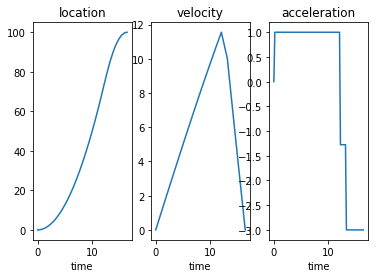

In [6]:
x = []
v = []
u = []
time=[]

for i in m.tau:
    time.append(value(m.time[i]))
    x.append(value(m.x[i]))
    v.append(value(m.v[i]))
    u.append(value(m.u[i]))
  
import matplotlib.pyplot as plt

plt.subplot(131)
plt.plot(time,x,label='x')
plt.title('location')
plt.xlabel('time')

plt.subplot(132)
plt.plot(time,v,label='v')
plt.xlabel('time')
plt.title('velocity')

plt.subplot(133)
plt.plot(time,u,label='a')
plt.xlabel('time')
plt.title('acceleration')

plt.show()

<!--NAVIGATION-->
< [2.5 Quadrature Rules](https://ndcbe.github.io/CBE60499/02.05-Quadrature-Rules.html) | [Contents](toc.html) | [2.6 Reaction Kinetics Example / Simulation with Pyomo.DAE](https://ndcbe.github.io/CBE60499/02.06-Reaction-DAE-Simulator-Example.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.06-Pyomo-DAE.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.06-Pyomo-DAE.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>